In [1]:
import numpy as np
import numpy.random as npr
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import time
import networkx as nx
import networkx.algorithms.bipartite as bpt
import networkx.algorithms.isomorphism as iso
import scipy.sparse as sp
import sys

In [2]:
def parse_adj(adj):
    print('-----------------------------------')
    for node in adj:
        print(f"{node:2d} -> ", end="")
        for neighbor in adj[node]:
            print(f"{neighbor:2d}", end=" ")
        print()
    print('-----------------------------------')

In [3]:
def draw_graph(G: nx.MultiGraph, shape: tuple[int, int]):
    m, n = shape
    pos = nx.layout.bipartite_layout(G, np.arange(m))
    
    # Draw the graph
    plt.figure(figsize=(9, 7))
    nx.draw(G, pos, labels={k:v for k, v in zip(list(range(m+n)), ([f'$c_{i}$' for i in range(m)]+[f'$n_{i}$' for i in range(n)]))},
            with_labels=True, node_color=['grey' if i < m else 'purple' for i in G.nodes()])
    plt.show()

# State Representation and Indexing

In order to keep track of the visited states and map their representation to the corresponding PS structures (namely, the $h$ and $g$ matrices, and a reward cache), we'll introduce the StateIndexer class. 

In [4]:
from state_indexer import StateIndexer

## Testing:

### Serialization/Deserialization

In [5]:
# Create a random graph from its biadjacency matrix. Let's allow for a few multiedges. 
m, n = (3, 7)
x = npr.randint(0, 3, (3, 7), dtype=np.uint8)
G = bpt.from_biadjacency_matrix(sp.csr_matrix(x), create_using=nx.MultiGraph())
x, G.edges

(array([[0, 1, 0, 2, 2, 0, 2],
        [0, 1, 0, 0, 2, 0, 1],
        [0, 0, 0, 1, 1, 1, 0]], dtype=uint8),
 MultiEdgeView([(0, 4, 0), (0, 6, 0), (0, 6, 1), (0, 7, 0), (0, 7, 1), (0, 9, 0), (0, 9, 1), (1, 4, 0), (1, 7, 0), (1, 7, 1), (1, 9, 0), (2, 6, 0), (2, 7, 0), (2, 8, 0)]))

In [6]:
# Now serialize it and then deserialize it
state_indexer = StateIndexer(graph_dims=(m, n))
d_serial = state_indexer.serialize_dense(G)
s_serial = state_indexer.serialize_sparse(G)
d_serial, s_serial

(b'\x00\x01\x00\x02\x02\x00\x02\x00\x01\x00\x00\x02\x00\x01\x00\x00\x00\x01\x01\x01\x00',
 b'\x00\x04\x07\n\x01\x03\x04\x06\x01\x04\x06\x03\x04\x05\x01\x02\x02\x02\x01\x02\x01\x01\x01\x01')

In [7]:
rec_G_d = state_indexer.deserialize_dense(d_serial)
rec_G_s = state_indexer.deserialize_sparse(s_serial)
assert rec_G_d.__class__ == nx.MultiGraph
assert rec_G_s.__class__ == nx.MultiGraph
assert (x == bpt.biadjacency_matrix(rec_G_d, row_order=np.arange(m)).astype(np.uint8).todense()).all()
assert (x == bpt.biadjacency_matrix(rec_G_s, row_order=np.arange(m)).astype(np.uint8).todense()).all()
assert nx.utils.graphs_equal(rec_G_d, G)
assert nx.utils.graphs_equal(rec_G_s, G)

## Graph Hashing

Here we want to have a notion of the collision rate. The number of collisions each hash key has will determine how expensive the insertion will be due to the isomorphism checks. 

In [8]:
from state_indexer import IsomorphicStateIndexer

In [9]:
m, n = 12, 24
state_indexer = IsomorphicStateIndexer(graph_dims=(m, n), debug=True)

avg_t = 0
for _ in range(1000):
    G = bpt.configuration_model(aseq=[4]*m, bseq=[2]*n, create_using=nx.MultiGraph)
    t = time.time()
    state_indexer.get_index(G)
    avg_t += time.time() - t

state_indexer.collision_report()
avg_t /= 1000
print(f"{avg_t = :5.2g} s")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153


KeyboardInterrupt: 

As it turns out, the hashing function is severely flawed, with one single hashkey having over 200 collisions among 1000 random matrices, implying a severe computational cost due to the quadratically many isomorphism checks that have to be performed. Unless I can come up with a better hashing scheme, this renders unfeasible the idea of grouping states by isomorphism class. 

In [42]:
# %timeit sp.kron(sp.coo_matrix(x), sp.eye(50))
# %timeit sp.csgraph.structural_rank(sp.csr_matrix(sp.eye(5000)))

matrix([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]], dtype=int16)

In [ ]:
# agent = initialize_agent()
# H, G = sp.lil, sp.dok
# r = 0
# for _ in range(num_episodes):
#     for _ in range(max_iter):
#         if r > 0 break
#         agent.sample_action() # uses current state agent.S
# inline: idx = state_indexer.get_index(S)
#         hi = H.getrow(idx)
#         action_idx = strat_sampling(hi)
#         agent.apply_action(action_idx) 
#         # internally convert a \in [0..A-1] to (i, j) indicating the pair of edges to twist
#         # apply action should update the state S accordingly
#         # or maybe you can just convert to (i, j) and then the state update + reward is handled by 
#         # the environment? it's what a. melnikov does anyway

## Graph Visualizations and Matrix Sorting

In [87]:
def repr(a):
  print('('+')\n('.join([''.join(r) for r in a.astype(int).astype(str)])+')')

(1100010)
(1001101)
(0111000)


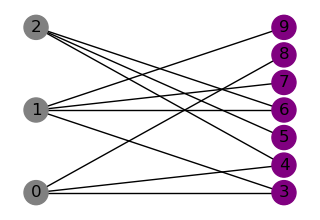

In [122]:
G = bpt.configuration_model(aseq=[4, 4, 4], bseq=[3, 2, 2, 2, 1, 1, 1], create_using=nx.Graph())
a = bpt.biadjacency_matrix(G, row_order=[0,1,2]).astype(np.bool_).todense()
repr(a)
pos = nx.layout.bipartite_layout(G, [0,1,2])

# Draw the graph
plt.figure(figsize=(3, 2))
nx.draw(G, pos, with_labels=True, node_color=['grey' if n in [0,1,2] else 'purple' for n in G.nodes()])
plt.show()

(1111000)
(1100111)
(1000110)


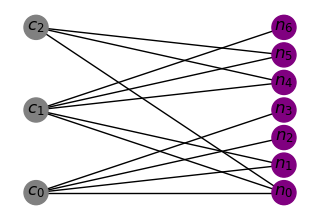

In [127]:
m, n = 3, 7
a = npr.randint(0, 2, (m, n), dtype=np.bool_)
repr(a)

G = bpt.from_biadjacency_matrix(sp.csr_matrix(a))
pos = nx.layout.bipartite_layout(G, [0,1,2])

# Draw the graph
plt.figure(figsize=(3, 2))
nx.draw(G, pos, labels={k:v for k, v in zip(list(range(m+n)), ([f'$c_{i}$' for i in range(m)]+[f'$n_{i}$' for i in range(n)]))},
        with_labels=True, node_color=['grey' if n in [0,1,2] else 'purple' for n in G.nodes()])
plt.show()

## Action encoding

In [115]:
m, n = 3, 7
def index_to_action(a: np.uint32) -> tuple[NDArray[np.uint8], 
                                           NDArray[np.uint8]]: 
    """
        Given an action index a in [0..A-1], A = n*(n-1)/2 * m(m-1)/2,
        compute (i, j), (k, l) indices of row pair and column pair where
        the braiding action is to be applied. 
    """
    # a = M*(n 2) + N
    M, N = np.divmod(a, n*(n-1)//2, dtype=np.uint16)
    # N = n i - (i+2)(i+1)/2 + j, M = m k - (k+2)(k+1)/2 + l
    i = np.floor(((2*n - 1) - np.sqrt((2*n-1)**2 - 8*N))//2)
    j = (N - n*i + ((i+2)*(i+1))//2)
    k = np.floor(((2*m - 1) - np.sqrt((2*m-1)**2 - 8*M))//2)
    l = (M - m*k + ((k+2)*(k+1))//2)
    
    return np.array([k, l]).astype(np.uint8), np.array([i, j]).astype(np.uint8)

def is_action_valid(state: NDArray[np.bool_], action: np.uint32) -> bool:
    submatrix = state[np.ix_(*index_to_action(action))]
    ID = np.eye(2, dtype=np.bool_)
    return (submatrix == ID).all() or (submatrix != ID).all()

In [123]:
repr(a)
print(a.dtype)

(1100010)
(1001101)
(0111000)
bool


In [124]:
sum([is_action_valid(a, k) for k in range(63)])

16

# Sparse Matrix formats

In [65]:
# %%timeit
S, A = 7, 30
h = sp.csr_array((), dtype=np.float32)
g = sp.dok_array((), dtype=np.float32)

gamma = 1e-3
eta = 1e-2
reward = 1

num_steps = 100
for _ in range(num_steps):
    h *= 1-gamma
    h += reward*g
    g *= 1-eta
    i, j = npr.randint(0, S), npr.randint(0, A)
    g[i, j] = 1

ValueError: unrecognized csr_matrix constructor usage

In [100]:
h.__dict__

{'_shape': (10, 30),
 'maxprint': 50,
 'indices': array([22, 17, 10,  8, 18, 27, 11, 28, 13, 26, 25,  0, 20, 16,  0,  7,  4,
        21, 10, 23, 22, 17,  3, 18, 27, 14, 25, 11, 25, 15,  4, 29,  9,  0,
         6,  1, 17, 14, 26,  2,  4, 18, 12,  7, 23, 25,  0, 25, 19,  3, 16,
        24, 29, 11,  1,  5,  7, 22,  2, 16, 17, 11, 20, 26, 10, 18,  8, 12,
         1,  8, 14, 29, 10, 15,  3, 23, 24], dtype=int32),
 'indptr': array([ 0, 14, 28, 36, 47, 57, 69, 77, 77, 77, 77], dtype=int32),
 'data': array([15.576905 , 21.941824 , 34.309803 , 45.334282 , 55.50186  ,
        58.270462 , 65.206955 , 55.165752 , 45.819855 , 41.767956 ,
        37.313423 , 32.42206  , 31.12668  , 21.177322 ,  6.772847 ,
        39.03317  , 40.14647  , 43.33285  , 54.009113 , 58.919537 ,
        70.629555 , 62.485176 , 63.80457  , 50.366398 , 47.704784 ,
        46.773674 , 34.924595 , 14.740188 , 13.894023 , 32.70946  ,
        42.556744 , 42.29579  , 62.52469  , 38.065212 , 25.636738 ,
        16.404272 , 10.4129

In [114]:
h.resize((30, 35))
h

<30x35 sparse array of type '<class 'numpy.float32'>'
	with 77 stored elements in Compressed Sparse Row format>

In [116]:
sp.csr_array(h.todense())

<30x35 sparse array of type '<class 'numpy.float32'>'
	with 77 stored elements in Compressed Sparse Row format>

In [108]:
# csc/csc = 319ms +- 7.57ms
# coo/dok = 448ms +- 8.85ms
# csc/dok = 495ms +- 14.4ms
# csr/dok = 464ms +- 17.6ms
# lil/dok = 19.2s +- 1.67s
# lil/lil = 27s +- 82.5ms